<h1><center>Super Market Sales Analytics</center></h1>

<h2>1) Data Science Proposal</h2>

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import skew
from prettytable import PrettyTable


# For feature selections and Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from collections import Counter
from sklearn.decomposition import PCA
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier

# Clustering
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import silhouetteplot
import scipy.cluster.hierarchy as sch
from sklearn.datasets import make_moons
from sklearn.metrics import adjusted_rand_score

# Importing the DecisionTreeClassifier and LogisticRegressionClassifier for model building
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection


# For Analyzing the models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix)
from sklearn.model_selection import cross_val_score

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from datetime import datetime

pd.options.mode.chained_assignment = None

In [2]:
#Read Data from the csv file
df = pd.read_csv('Supermarket_Sales_Dataset.csv')
df.head(2)

,Invoice ID,Branch,City,Customer Type,Gender,Product Type,Unit Price,Quantity,Tax,Selling Price,Date,Time,Payment Type,Cost Price,Gross Income,Rating
0,750-67-8428,A,Bangalore,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Debit card,522.83,26.1415,9.1
1,226-31-3081,C,Mysore,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,3.8200,9.6


In [3]:
#Defining class colour
class color:
   BLUE = '\033[94m'
   BOLD = '\033[1m'
   END = '\033[0m'

<h2>Objectives</h2>

<h5>1) Which city has a better sale for products in the Electronic Accessories product line? </h5>

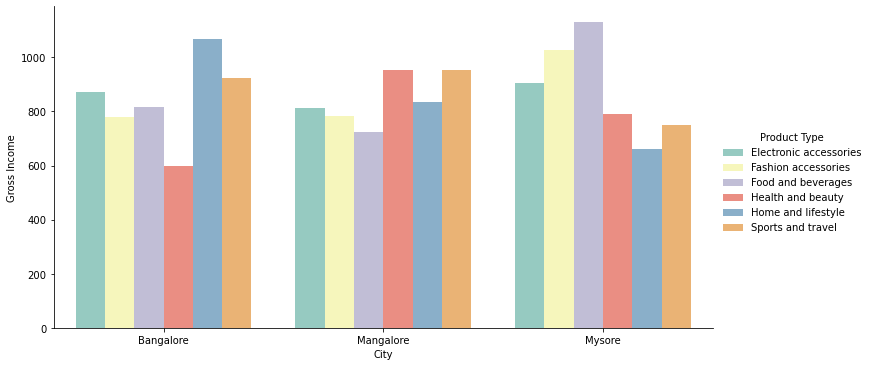

,City,Product Type,Gross Income
12,Mysore,Electronic accessories,903.2845


In [5]:
dfCat=df[['City','Product Type','Gross Income']].groupby(['City','Product Type'],as_index=False).sum()
sns.catplot(data=dfCat, y='Gross Income', x='City',kind='bar', hue='Product Type',height=5,aspect=2,palette="Set3")
plt.show()

dfCat[dfCat['Product Type'] == 'Electronic accessories'].nlargest(1,'Gross Income')

<h5>2) Which payment method is used more often at a particular city, branch and for which product type ? </h5>

In [18]:
dfpm=df[['City','Product Type','Payment Type','Invoice ID']].groupby(['City','Product Type','Payment Type'],as_index=False).count()
dfpm.sort_values(by = ['City', 'Invoice ID'], ascending = [True, False],inplace = True)
dfpm.drop_duplicates(subset="City",inplace = True)                  
dfpm.head()

,City,Product Type,Payment Type,Invoice ID
14,Bangalore,Home and lifestyle,Debit card,26
33,Mangalore,Sports and travel,Cash,26
42,Mysore,Food and beverages,Cash,31


<h5>3) Which Product type has been more purchased by female customers? </h5>

In [7]:
dfgender=df[['Gender','Product Type','Quantity']].groupby(['Gender','Product Type'],as_index=False).sum()
dfgender[dfgender['Gender'] == 'Female'].nlargest(1,'Quantity')

,Gender,Product Type,Quantity
1,Female,Fashion accessories,530


<h5>4) In which month does the highest number of home and lifestyle products have been sold ? </h5>

In [8]:
dfm = df[df['Product Type'] == 'Home and lifestyle']
dfm['Date'] = pd.to_datetime(dfm['Date'])
dfm['Month'] = dfm['Date'].dt.month_name(locale = 'English')
dfmtrend = dfm[['Month','Quantity']].groupby([dfm['Month']]).sum()
dfmtrend.sort_values(by = ['Quantity'], ascending = [False],inplace = True)
dfmtrend.head(1)

,Quantity
Month,
March,364


<h5>5) At what time most of the female customers are purchasing products ? </h5>

In [9]:
dff = df[df['Gender'] == 'Female']
dfft = dff[['Gender','Time','Invoice ID']]
dfft['Invoice ID Count'] = dfft['Invoice ID']
dfff=dfft[['Gender','Time','Invoice ID Count']].groupby(['Gender','Time'],as_index=False).count()
dfff.sort_values(by = ['Invoice ID Count'], ascending = False,inplace = True)
dfff.drop_duplicates(subset="Time",inplace = True)
dfff.head(1)

,Gender,Time,Invoice ID Count
168,Female,14:42,6


<h2>2) Exploratory Data Analysis</h2>

In [4]:
#Size of the Dataset
print(color.BLUE + color.BOLD + "\nSize of Dataset:" + color.END)
print(df.shape)


Size of Dataset:
(1000, 16)


In [5]:
# Attribute and its datatype
ptbl = PrettyTable()

for attribute in df.columns:    
    ptbl.field_names = ["Attribute Name", "Data Type"]
    ptbl.add_row([attribute, df[attribute].dtype])
    
print(ptbl)

+----------------+-----------+
| Attribute Name | Data Type |
+----------------+-----------+
|   Invoice ID   |   object  |
|     Branch     |   object  |
|      City      |   object  |
| Customer Type  |   object  |
|     Gender     |   object  |
|  Product Type  |   object  |
|   Unit Price   |  float64  |
|    Quantity    |   int64   |
|      Tax       |  float64  |
| Selling Price  |  float64  |
|      Date      |   object  |
|      Time      |   object  |
|  Payment Type  |   object  |
|   Cost Price   |  float64  |
|  Gross Income  |  float64  |
|     Rating     |  float64  |
+----------------+-----------+


In [6]:
#Distribution Of Data
distTxt = color.BLUE + color.BOLD + "Data Distribution" + color.END
print(distTxt.center(100))
df.describe()

                                   Data Distribution                                   


,Unit Price,Quantity,Tax,Selling Price,Cost Price,Gross Income,Rating
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000
mean,55.672130,5.510000,15.379369,322.966749,307.58738,15.379369,6.97270
std,26.494628,2.923431,11.708825,245.885335,234.17651,11.708825,1.71858
min,10.080000,1.000000,0.508500,10.678500,10.17000,0.508500,4.00000
25%,32.875000,3.000000,5.924875,124.422375,118.49750,5.924875,5.50000
50%,55.230000,5.000000,12.088000,253.848000,241.76000,12.088000,7.00000
75%,77.935000,8.000000,22.445250,471.350250,448.90500,22.445250,8.50000
max,99.960000,10.000000,49.650000,1042.650000,993.00000,49.650000,10.00000


In [7]:
columnsList = list(df)
categoricalList = list(df.select_dtypes(include=['object']).columns)
numericalList = list(set(columnsList) - set(categoricalList))

#Character or Numerical Data
print(color.BLUE + color.BOLD + "Categorical Data:" + color.END)
print(categoricalList)
print(color.BLUE + color.BOLD + "\nNumerical Data:" + color.END)
print(numericalList)

Categorical Data:
['Invoice ID', 'Branch', 'City', 'Customer Type', 'Gender', 'Product Type', 'Date', 'Time', 'Payment Type']

Numerical Data:
['Rating', 'Selling Price', 'Quantity', 'Cost Price', 'Unit Price', 'Gross Income', 'Tax ']


Classification of Rating Level:
High    659
Low     341
Name: RatingLevel, dtype: int64


<AxesSubplot:ylabel='RatingLevel'>

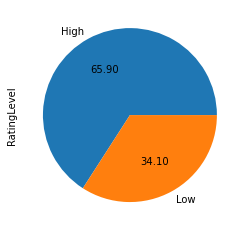

In [9]:
df['RatingLevel'] = pd.cut(x=df['Rating'],
                     bins=[1, 6, 10],
                     labels=['Low', 'High'])

#Balanced or Imbalanced Dataset
print(color.BLUE + color.BOLD + "Classification of Rating Level:" + color.END)
count = df['RatingLevel'].value_counts()
print(count)
count.plot.pie(autopct='%.2f')

<h3>Data Visualization</h3>

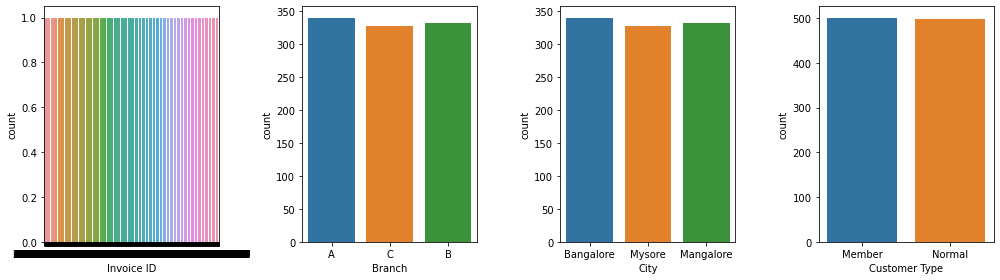

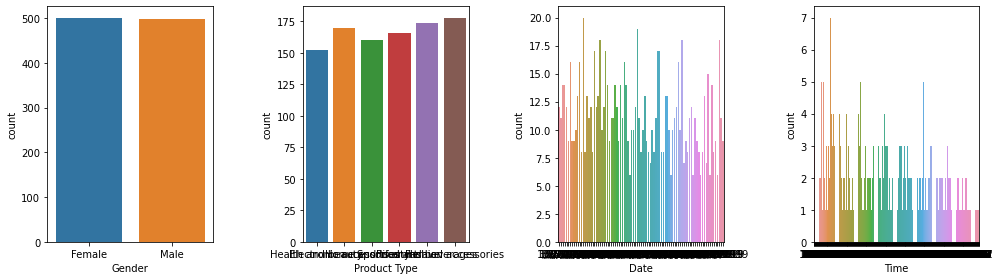

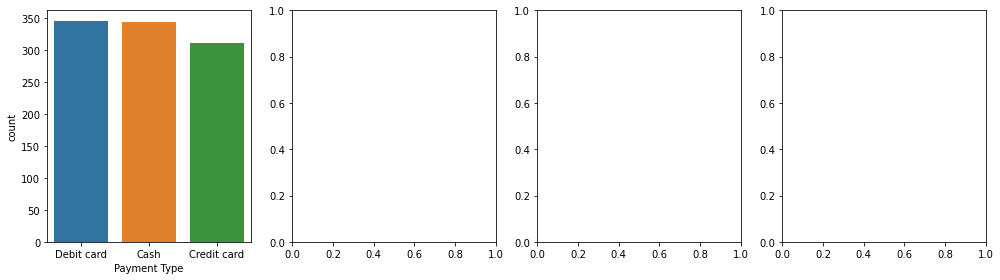

In [17]:
#Count Plots (for categorical attributes)

plt.rcParams["figure.figsize"] = [14.00, 4.0]
plt.rcParams["figure.autolayout"] = True

index = 0
graphsInARow = 4

for attr in categoricalList:
    
    if (index % graphsInARow == 0):
        f, ax = plt.subplots(1, graphsInARow)
        
    sns.countplot(x=attr, data=df, ax = ax[index % graphsInARow])
    index = index + 1
    
    if (index % graphsInARow == 0):
        plt.show()

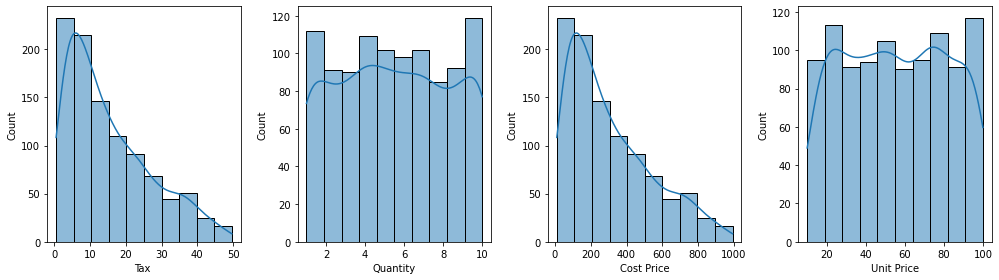

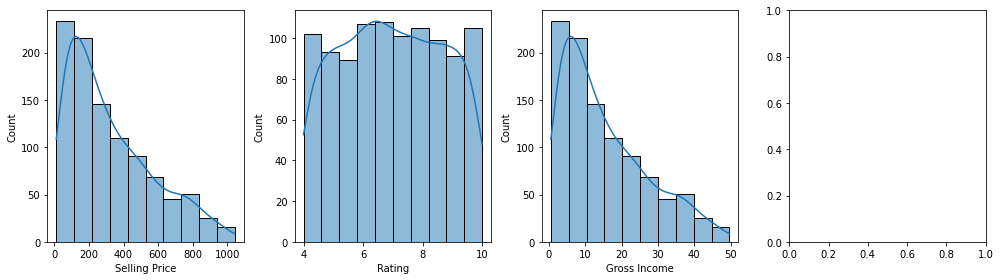

In [14]:
#Histogram Distribution (for Continuous Attributes)
plt.rcParams["figure.figsize"] = [14.00, 4.0]
plt.rcParams["figure.autolayout"] = True

index = 0
graphsInARow = 4

for attr in numericalList:
    if (index % graphsInARow == 0):
        f, ax = plt.subplots(1, graphsInARow)
    sns.histplot(data=df[attr], bins=10, kde=True, ax = ax[index % graphsInARow])
    index = index + 1
    if (index % graphsInARow == 0):
        plt.show()

                                         Correlation Using HeatMap                                         


<AxesSubplot:>

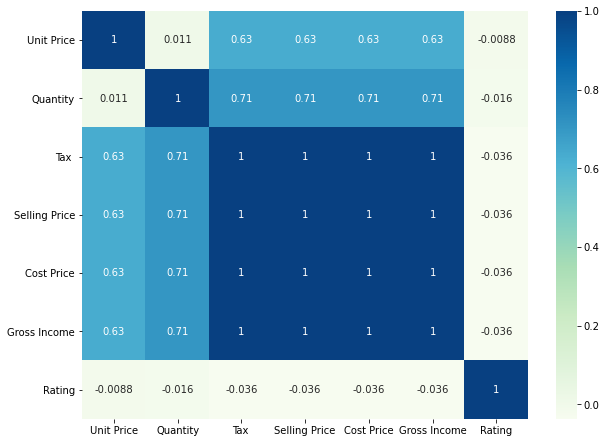

In [10]:
#Correlation of the features in the dataset
corr = df.corr()

corrTxt = color.BLUE + color.BOLD + "Correlation Using HeatMap" + color.END
print(corrTxt.center(120))

#Visualizing correlation using Heatmap
plt.figure(figsize=(10,7.5))
sns.heatmap(corr, annot=True, cmap='GnBu')

<h2>3) Data Wrangling</h2>

In [11]:
#Count of NaN/Null values from dataset
print(color.BLUE + color.BOLD + "\nCount of NaN/Null values for each feature:" + color.END)
print(df.isna().sum())


Count of NaN/Null values for each feature:
Invoice ID       0
Branch           0
City             0
Customer Type    0
Gender           0
Product Type     0
Unit Price       0
Quantity         0
Tax              0
Selling Price    0
Date             0
Time             0
Payment Type     0
Cost Price       0
Gross Income     0
Rating           0
RatingLevel      0
dtype: int64


In [12]:
# Checking for duplicates
df.duplicated().sum()

0

In [13]:
# Dropping the attributes that has a unique number(number assignment) for all the rows or attributes derivable from other features 
df=df.drop(['Invoice ID','Branch', 'Date', 'Time'], axis=1)

In [14]:
df.shape

(1000, 13)

In [15]:
df.head(2)

,City,Customer Type,Gender,Product Type,Unit Price,Quantity,Tax,Selling Price,Payment Type,Cost Price,Gross Income,Rating,RatingLevel
0,Bangalore,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,Debit card,522.83,26.1415,9.1,High
1,Mysore,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,Cash,76.40,3.8200,9.6,High


<h2>4) Clustering </h2>

In [16]:
#Copy of df
dfCopy = df

for column in dfCopy.columns:
        if dfCopy[column].dtype == 'int64': #If Column data type is Int i.e, numerical continue
            continue
        dfCopy[column] = LabelEncoder().fit_transform(dfCopy[column].astype(str)) #If Column data type is not Int, encode and transform to Numerical
    

In [17]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dfCopy)

In [18]:
import warnings
warnings.filterwarnings('ignore')

kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

silhouette_coefficients = []
for k in range(2, 5):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)

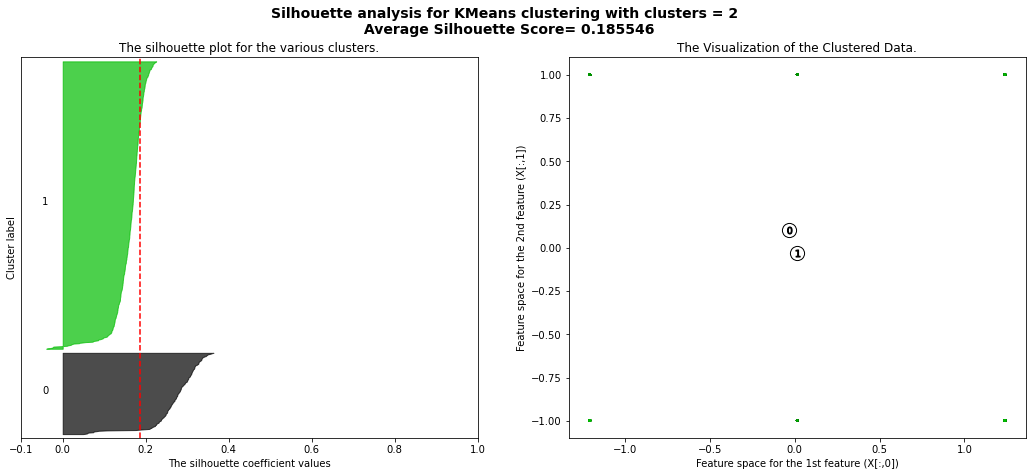

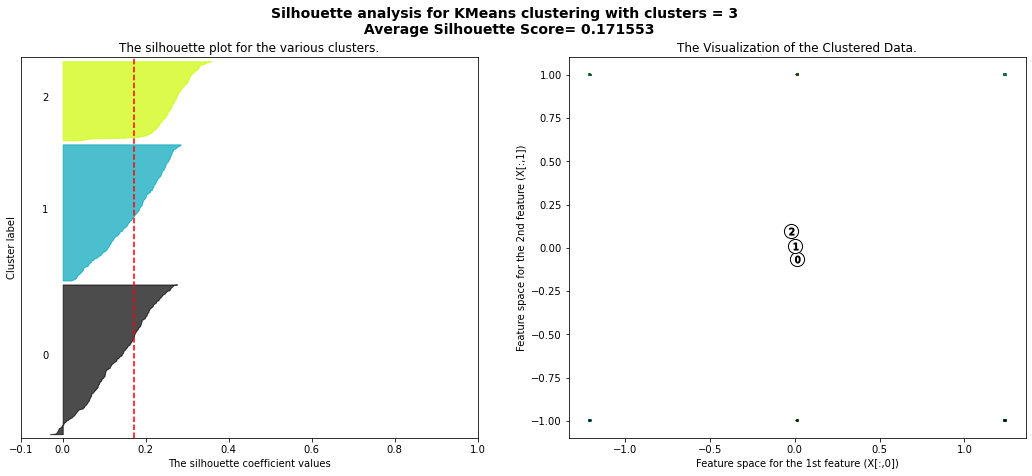

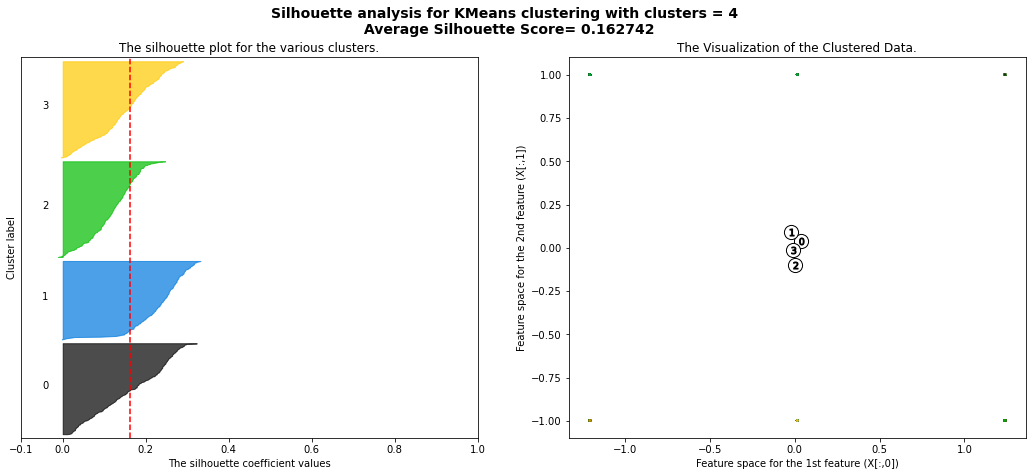

In [19]:
silhouetteplot.plot(scaled_features, [2, 3, 4])

In [21]:
silhouette_coefficients_medoid = []
for k in range(2, 5):
    kmedoids = KMedoids(k).fit(scaled_features)
    score = silhouette_score(scaled_features, kmedoids.labels_)
    silhouette_coefficients_medoid.append(score)

In [22]:
silhouette_coefficients_ahc = []
for k in range(2, 5):
    cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')

    cluster.fit_predict(scaled_features)
    score = silhouette_score(scaled_features, cluster.labels_)
    silhouette_coefficients_ahc.append(score.round(2))

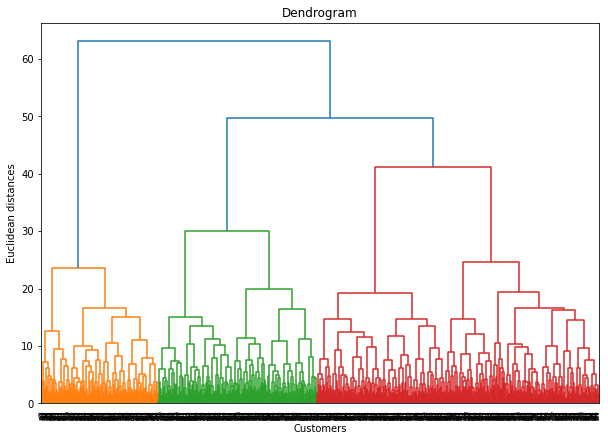

In [23]:
plt.figure(figsize=(10, 7))

dendrogram = sch.dendrogram(sch.linkage(scaled_features, method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

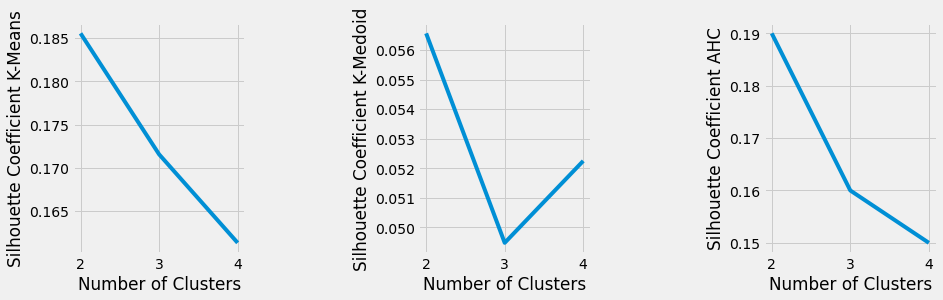

In [24]:
plt.style.use("fivethirtyeight")
plt.subplot(1,3,1)
plt.plot(range(2, 5), silhouette_coefficients)
plt.xticks(range(2, 5))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient K-Means")

plt.style.use("fivethirtyeight")
plt.subplot(1,3,2)
plt.plot(range(2, 5), silhouette_coefficients_medoid)
plt.xticks(range(2, 5))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient K-Medoid")

plt.style.use("fivethirtyeight")
plt.subplot(1,3,3)
plt.plot(range(2, 5), silhouette_coefficients_ahc)
plt.xticks(range(2, 5))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient AHC")

# set the spacing between subplots
plt.subplots_adjust(left=1,
                    bottom=0.1,
                    right=3,
                    top=0.9,
                    wspace=1,
                    hspace=1)

plt.show()

In [25]:
dfCopy, true_labels = make_moons(
    n_samples=250, noise=0.05, random_state=42
)

In [26]:
# Instantiate k-means and dbscan algorithms
kmeans = KMeans(n_clusters=2)
kmedoids = KMedoids(n_clusters=2)
ahc = AgglomerativeClustering(n_clusters=2)

# Fit the algorithms to the features
kmeans.fit(scaled_features)
kmedoids.fit(scaled_features)
ahc.fit_predict(scaled_features)

# Compute the silhouette scores for each algorithm
kmeans_silhouette = silhouette_score(
    scaled_features, kmeans.labels_
).round(3)
kmedoids_silhouette = silhouette_score(
   scaled_features, kmedoids.labels_
).round (3)
ahc_silhouette = silhouette_score(
   scaled_features, ahc.labels_
).round (3)

In [27]:
print(kmeans_silhouette)

print(kmedoids_silhouette)

print(ahc_silhouette)

0.186
0.057
0.186


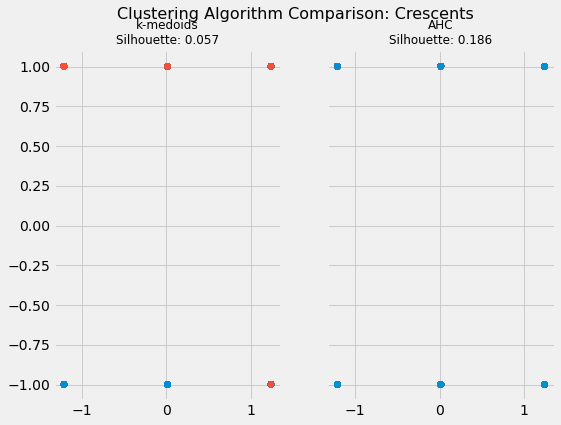

In [28]:
# Plot the data and cluster silhouette comparison
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(8, 6), sharex=True, sharey=True
)
fig.suptitle(f"Clustering Algorithm Comparison: Crescents", fontsize=16)
fte_colors = {
    0: "#008fd5",
    1: "#fc4f30",
}
# The k-medoids plot
kd_colors = [fte_colors[label] for label in kmedoids.labels_]
ax1.scatter(scaled_features[:, 0], scaled_features[:, 1], c=kd_colors)
ax1.set_title(
    f"k-medoids\nSilhouette: {kmedoids_silhouette}", fontdict={"fontsize": 12}
)

# The ahc plot
ahc_colors = [fte_colors[label] for label in ahc.labels_]
ax2.scatter(scaled_features[:, 0], scaled_features[:, 1], c=ahc_colors)
ax2.set_title(
    f"AHC\nSilhouette: {ahc_silhouette}", fontdict={"fontsize": 12}
)
plt.show()

In [29]:
#Feature Selection 1 - Filter Method(Removing Higher Correlated features)
def featSelectFilter(dfFeat1):
    # Create correlation matrix
    corr_matrix = corr.abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype('bool'))

    # Get features with correlation greater than 0.75
    to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]

    print(color.BLUE + color.BOLD + 'Features removed since correlation is higher:' + color.END)
    print(to_drop)

    # Drop features 
    dfFeat1.drop(list(to_drop), axis=1, inplace=True)
    
    #Size of the Dataset
    print(color.BLUE + color.BOLD + "\nSize of Dataset:" + color.END)
    print(dfFeat1.shape)
    
    return dfFeat1

In [45]:
#Transform the non numerical data into numerical
def transformToNumerical(dfFeat1):
    for column in dfFeat1.columns:
        if dfFeat1[column].dtype == 'int64': #If Column data type is Int i.e, numerical continue
            continue
        dfFeat1[column] = LabelEncoder().fit_transform(dfFeat1[column].astype(str)) #If Column data type is not Int, encode and transform to Numerical
    
    print(color.BLUE + color.BOLD + 'After Encoding to numerical(First 10 records):\n' + color.END)
#    print(dfFeat1.head(10)) #Print first 10 records of dataset after encoding
    
    return dfFeat1

In [48]:
def minMaxScaler(dfFeat1):
    # Using Min Max Scaler
    min_max_scaler = MinMaxScaler()
    min_max_scaled = min_max_scaler.fit_transform(dfFeat1)

    # Creating new Data frame with the scaled value
    FE1_Norm = pd.DataFrame(min_max_scaled, columns = dfFeat1.columns)

    return FE1_Norm

In [31]:
#Split the entire dataset to Train and Test 
def splitTrainTest(dfFeat1, dfFeat2):
#     X = attData1.iloc[:, 1:attData2.shape[1]] #From the second column, all the columns taken for train dataset
#     Y = attData1.iloc[:, 0] #First Column 'Attrition' taken as test dataset
    
    #Splitting the dataset
    X = dfFeat1.iloc[:, 0:dfFeat2.shape[1]]
    X = X.drop(['RatingLevel','Rating'], axis=1)
    Y = dfFeat1.iloc[:, -1]
    
    #Split the data into 75% training and 25% testing
    return train_test_split(X, Y, test_size = 0.25, random_state = 0)

In [32]:
#Standardization or z-score normalization
def tranformationZScore(X_train, X_test):
    scaler = StandardScaler()
    
    # Fit on training set only.
    scaler.fit(X_train)
    
    # Apply transform to both the training set and the test set.
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    print(color.BLUE + color.BOLD + 'Standardized or z-score Normalized Train and Test Dataset:\n' + color.END)
#     print(X_train)
#     print(X_test)
    
    return X_train, X_test

In [33]:
#Dimensionality Reduction using PCA
def dimReductionPCA(X_train, X_test):
    # Make an instance of the Model
    pca = PCA(.95)

    pca.fit(X_train)

    X_train = pca.transform(X_train) #PCA transformation on Train Set
    X_test = pca.transform(X_test) #PCA transformation on Test Set

    #How much information (variance) attributed to each of the principal components
    explained_variance = pca.explained_variance_ratio_
    print(color.BLUE + color.BOLD + 'Variance attributed to each of the principal components:' + color.END)
    print(explained_variance)
    
    return X_train, X_test

In [34]:
#Handling the Dataset Imbalance Using Hybridization: SMOTE + Tomek Links
def handleClassImbalance(X_train, Y_train):
    
    counter = Counter(Y_train) #Before Sampling, count of Y_train
    print(color.BLUE + color.BOLD + 'Before Sampling:' + color.END)
    print(counter)

    #Oversampling the train dataset using SMOTE + Tomek
    smtom = SMOTETomek(random_state=0)  #To get better class clusters, Tomek links are applied to oversampled minority class samples done by SMOTE
    X_train_smtom, y_train_smtom = smtom.fit_resample(X_train, Y_train) #Fit the resampled model

    counter = Counter(y_train_smtom) #After Sampling, Count of y_train_smtom
    print(color.BLUE + color.BOLD + 'After Sampling:' + color.END)
    print(counter)
    
    return X_train_smtom, y_train_smtom

In [35]:
#Train the model using Random Forest classifier - This meta estimator fits a number of decision tree classifiers on sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.
def randomForestModel(X_train_smtom, y_train_smtom):
    #Number of trees given as '10' with criterion 'entropy' and seed for random generator is set as '0' 
    randomforest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0) 
    randomforest.fit(X_train_smtom, y_train_smtom)

    return randomforest

In [54]:
#Plotting top 6 features that help in predicting using the Random Forest Built-in Feature Importance 
def importantFeatures(randomforest, dfFeat1):
    #Determine the feature importance values
    importances = randomforest.feature_importances_ 
    
    #Create a dictionary with the importances values
    important_features_dict = {}
    for idx, val in enumerate(importances): 
        important_features_dict[idx] = val
    
    #Sort the feature importances in descending order
    important_features_list = sorted(important_features_dict,
                                     key=important_features_dict.get,
                                     reverse=True)[1:]

    important_features = dfFeat1.columns[important_features_list]

    #Visualize the top 6 feature importance using bar chart
    feat_importances = pd.Series(importances[important_features_list], index=important_features)
    feat_importances.nlargest(6).plot(kind='barh')
    plt.xlabel('Feature Importance')
    plt.title('Top 6 Features With Higher Random Forest Feature Importance')
    plt.show()

In [37]:
#Create Machine Learning models – Logistic regression and Decision tree to predict
def mlPredict(X_train_smtom, y_train_smtom, Y_test):
    cv_dataFrames = []
    
    # Prepare Machine Learning models – Logistic regression and Decision tree
    models = []
    
    #Parametric Supervised learning model based on probability
    models.append(('Logistic Regression(LR)', LogisticRegression()))
    #Non-Parametric Supervised learning model by learning simple decision rules inferred from the data features
    models.append(('Decision Tree(CART)', DecisionTreeClassifier())) 

    results = []
    mNames = [] #List for collecting model names
    
    #List of scoring metrics for comparison of models
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc'] 
    
    targ_names = ['Low', 'High'] #List of target values
    
    for mName, model in models: #Looping through each of the models
        
            #Split the dataset into '5' folds and Each fold is used once as a validation while the '5 - 1' remaining folds form the training set
            #Shuffle is set to 'True' to shuffle the data before splitting into batches
            #Random_state affects the ordering of the indices, which controls the randomness of each fold
            kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210) 
            
            #Evaluate metrics by cross-validation
            cv_res = model_selection.cross_validate(model, X_train_smtom, y_train_smtom, cv=kfold, scoring=scoring)
            
            #Fit the model and predict the label of test set
            ml = model.fit(X_train_smtom, y_train_smtom) 
            y_pred = ml.predict(X_test)
            
            print(color.BLUE + color.BOLD + mName + color.END)
            
            #Number of correct and incorrect predictions compared wih Actual class and Predicted class
            cm = confusion_matrix(Y_test, y_pred)

            TN = cm[0][0] #True Negative(Model predicted No and the Actual is also No, classifier is getting things right)
            TP = cm[1][1] #True Positive(Model predicted Yes and the Actual is also Yes, classifier is getting things right)
            FN = cm[1][0] #False Negative(Model predicted No and the Actual is Yes, classifier is getting things wrong i.e, mislabelling)
            FP = cm[0][1] #False Positive(Model predicted Yes and the Actual is No, classifier is getting things wrong i.e, mislabelling)

            print(color.BOLD + "\nConfusion Matrix:" + color.END)
            
            column_names = ['Predicted Low', 'High']
            row_names    = ['Actual Low', 'High']
            
            cm_df = pd.DataFrame(cm, columns=column_names, index=row_names)
            
            print(cm_df)
            
            #Accuracy determines how often is classifier correct, (TP+TN)/Total
            print(color.BOLD + "\nAccuracy:" + color.END)
            print(round(accuracy_score(Y_test, y_pred) * 100, 2),"%")
            
            #Return the list of scores calculated for each cv='10' folds, estimator object implementing ‘fit’ and n_jobs='-1' means using all processors
            cross_val_lr = cross_val_score(estimator = model, X = X_train_smtom, y = y_train_smtom, cv = 10, n_jobs = -1)
            print(color.BOLD + "\nCross Validation Accuracy:" + color.END)
            print(round(cross_val_lr.mean() * 100 , 2),"%")
            
            #Report showing the main classification metrics with the target names 'Yes' and 'No'
            print(color.BOLD + "\nClassification Report:" + color.END)
            print(classification_report(Y_test, y_pred, target_names=targ_names))
            
            #Get False Positive Rates and True Postive rates for the Classifiers
            #By roc_curve module by passing the test dataset and the predicted data through it
            print(color.BOLD + "\nReceiver Operating Characteristic(ROC):" + color.END)
            false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(Y_test, y_pred)
            
            #Ploting ROC Curves with False Positive Rate on X-axis and True Positive Rate on Y-axis
            title = 'Receiver Operating Characteristic(ROC) - ' + mName
            plt.subplots(1, figsize=(10,10))
            plt.title(title)
            plt.plot(false_positive_rate1, true_positive_rate1)
            plt.plot([0, 1], ls="--")
            plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')
            
            results.append(cv_res) #Appending the cross validation metrics
            mNames.append(mName) #Appending each of the model names

            dataFrame = pd.DataFrame(cv_res) #Create data frame of cross validation results
            dataFrame['model'] = mName #Add the model name to dataframe
            cv_dataFrames.append(dataFrame) #Append each of the data frames
            
            result = pd.concat(cv_dataFrames, ignore_index=True) #Concatenate the the dataframes object ingnoring index
    return result

In [38]:
#Comparison of Performance of Logistic Regression and Decision tree models
def ml_ModelsComparison(result):
    mlValues = []
    
    #Iterating through result values and append the values of each models to mlValues[]
    for model in list(set(result.model.values)): 
        m_dataFrame = result.loc[result.model == model]
        mlValue = m_dataFrame.sample(n=30, replace=True)
        mlValues.append(mlValue)

    m_dataFrame = pd.concat(mlValues, ignore_index=True) #Concatenate the the dataframes object ingnoring index
    
    #Massage a DataFrame into a format where identifier variable is 'model', variable column 'metrics' and value column 'values'
    perf_results = pd.melt(m_dataFrame,id_vars=['model'],var_name='metrics', value_name='values')
    
    tym_metrics = ['fit_time','score_time'] # Fit time Metrics
    
    #Performance Metrics
    perf_results_nofit = perf_results.loc[~perf_results['metrics'].isin(tym_metrics)] # Get dataframe without fit data
    perf_results_nofit = perf_results_nofit.sort_values(by='values') #Sort the performance result on its values

    #Visualization of Comparison of LR and CART Model using BoxPlot
    plt.figure(figsize=(20, 12))
    sns.set(font_scale=2.0)
    g = sns.boxplot(x="model", y="values", hue="metrics", data=perf_results_nofit, palette="Set3")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Comparison of LR and CART Model by Classification Metric')

    return perf_results_nofit, m_dataFrame

In [96]:
def select_featureschi(X_train, y_train):
    fs = SelectKBest(score_func=chi2, k=5)
    fs.fit_transform(X_train, y_train)
    return fs


def selected_features_chi2(dfFeat2):
    #Splitting the dataset
    X = dfFeat2.iloc[:, 0:dfFeat2.shape[1]]
    X = X.drop(['RatingLevel','Rating'], axis=1)
    y = dfFeat2.iloc[:, -1]

    fs = select_featureschi(X, y)

#     for i in range(len(fs.scores_)):
#         print('Train Feature',list(X.columns)[i])
#         print('Chi-square %d: %f' % (i+1, fs.scores_[i]))


    selected_features_chi2 = list(X.columns[fs.get_support(indices=True)])
    return selected_features_chi2

In [97]:
def select_featuresinfo(X_train, y_train):
    fs = SelectKBest(score_func=mutual_info_classif, k=5)
    fs.fit_transform(X_train, y_train)
    return fs

def selected_features_mutual_info(dfFeat2):
    #Splitting the dataset
    X = dfFeat2.iloc[:, 0:dfFeat2.shape[1]]
    X = X.drop(['RatingLevel','Rating'], axis=1)
    y = dfFeat2.iloc[:, -1]

    fs = select_featuresinfo(X, y)


#     for i in range(len(fs.scores_)):
#         print('Train Feature %d: %f' % (i, fs.scores_[i]))
#         print('Train Feature',list(X.columns)[i])


    selected_features_mutual_info = list(X.columns[fs.get_support(indices=True)])
    return selected_features_mutual_info

In [42]:
#Feature Selection 1 - Filter Method(Removing Higher Correlated features)
dfFeature1 = df #Create a copy of attData dataset
dfFeature1 = featSelectFilter(dfFeature1)

Features removed since correlation is higher:
['Selling Price', 'Cost Price', 'Gross Income']

Size of Dataset:
(1000, 10)


In [46]:
#Feature Encoding (To Numerical)
dfFeature1 = transformToNumerical(dfFeature1)
dfFeature1.head(2)

After Encoding to numerical(First 10 records):



,City,Customer Type,Gender,Product Type,Unit Price,Quantity,Tax,Payment Type,Rating,RatingLevel
0,0,0,0,3,596,7,344,2,43,0
1,2,1,0,0,386,5,470,0,49,0
2,0,1,1,4,227,7,58,1,22,0
3,0,0,1,3,388,8,285,2,35,0
4,0,1,1,5,733,7,485,2,56,1
5,2,1,1,0,722,7,399,2,4,1
6,0,0,0,0,503,6,220,2,3,1
7,2,1,0,4,575,10,565,2,30,0
8,0,0,0,3,105,2,449,1,20,0
9,1,0,0,2,341,3,893,1,5,1


In [49]:
dfFeature1 = minMaxScaler(dfFeature1)
dfFeature1.head(2)

,City,Customer Type,Gender,Product Type,Unit Price,Quantity,Tax,Payment Type,Rating,RatingLevel
0,0.0,0.0,0.0,0.6,0.632696,0.666667,0.347826,1.0,0.716667,0.0
1,1.0,1.0,0.0,0.0,0.409766,0.444444,0.475228,0.0,0.816667,0.0


In [50]:
#Splitting the Dataset to Train and Test
X_train, X_test, Y_train, Y_test = splitTrainTest(dfFeature1, dfFeature1)

In [51]:
#PCA Dimensionality Reduction
X_train, X_test = dimReductionPCA(X_train, X_test)

Variance attributed to each of the principal components:
[0.21564773 0.19234234 0.13968728 0.13569575 0.0954789  0.08483018
 0.07070127 0.06561655]


In [52]:
#Handling Imbalanced Dataset
X_train_smtom, y_train_smtom = handleClassImbalance(X_train, Y_train)

Before Sampling:
Counter({0.0: 510, 1.0: 240})
After Sampling:
Counter({1.0: 470, 0.0: 470})


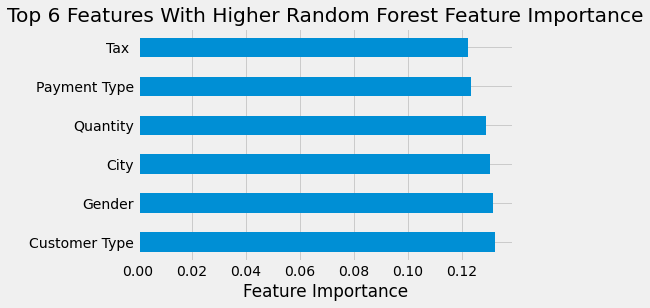

In [55]:
#RandomForest Model for important features
randomforest = randomForestModel(X_train_smtom, y_train_smtom)
importantFeatures(randomforest, dfFeature1)

Logistic Regression(LR)

Confusion Matrix:
            Predicted Low  High
Actual Low             88    61
High                   55    46

Accuracy:
53.6 %

Cross Validation Accuracy:
54.36 %

Classification Report:
              precision    recall  f1-score   support

         Low       0.62      0.59      0.60       149
        High       0.43      0.46      0.44       101

    accuracy                           0.54       250
   macro avg       0.52      0.52      0.52       250
weighted avg       0.54      0.54      0.54       250


Receiver Operating Characteristic(ROC):
Decision Tree(CART)

Confusion Matrix:
            Predicted Low  High
Actual Low             86    63
High                   60    41

Accuracy:
50.8 %

Cross Validation Accuracy:
67.77 %

Classification Report:
              precision    recall  f1-score   support

         Low       0.59      0.58      0.58       149
        High       0.39      0.41      0.40       101

    accuracy                          

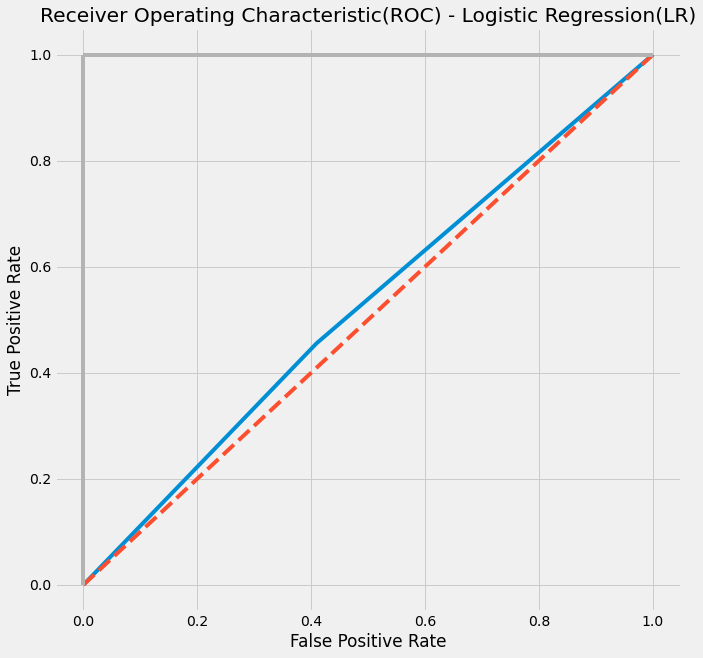

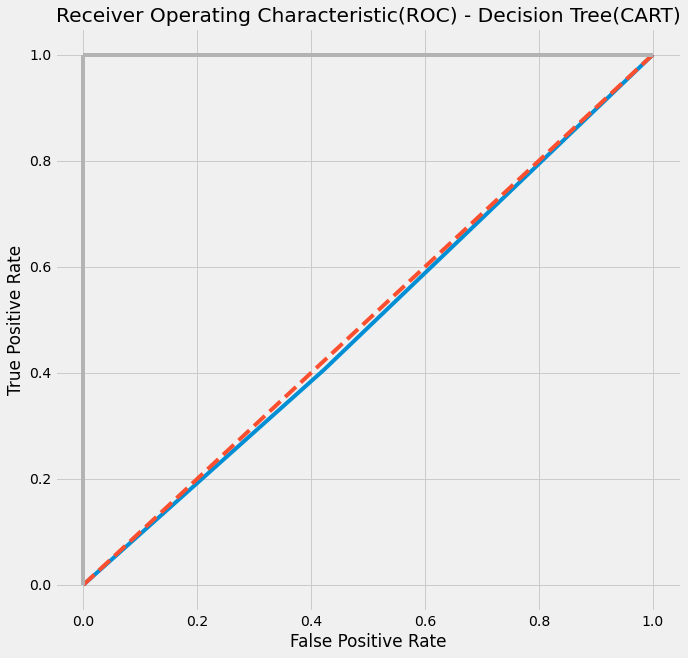

In [56]:
result = mlPredict(X_train_smtom, y_train_smtom, Y_test)

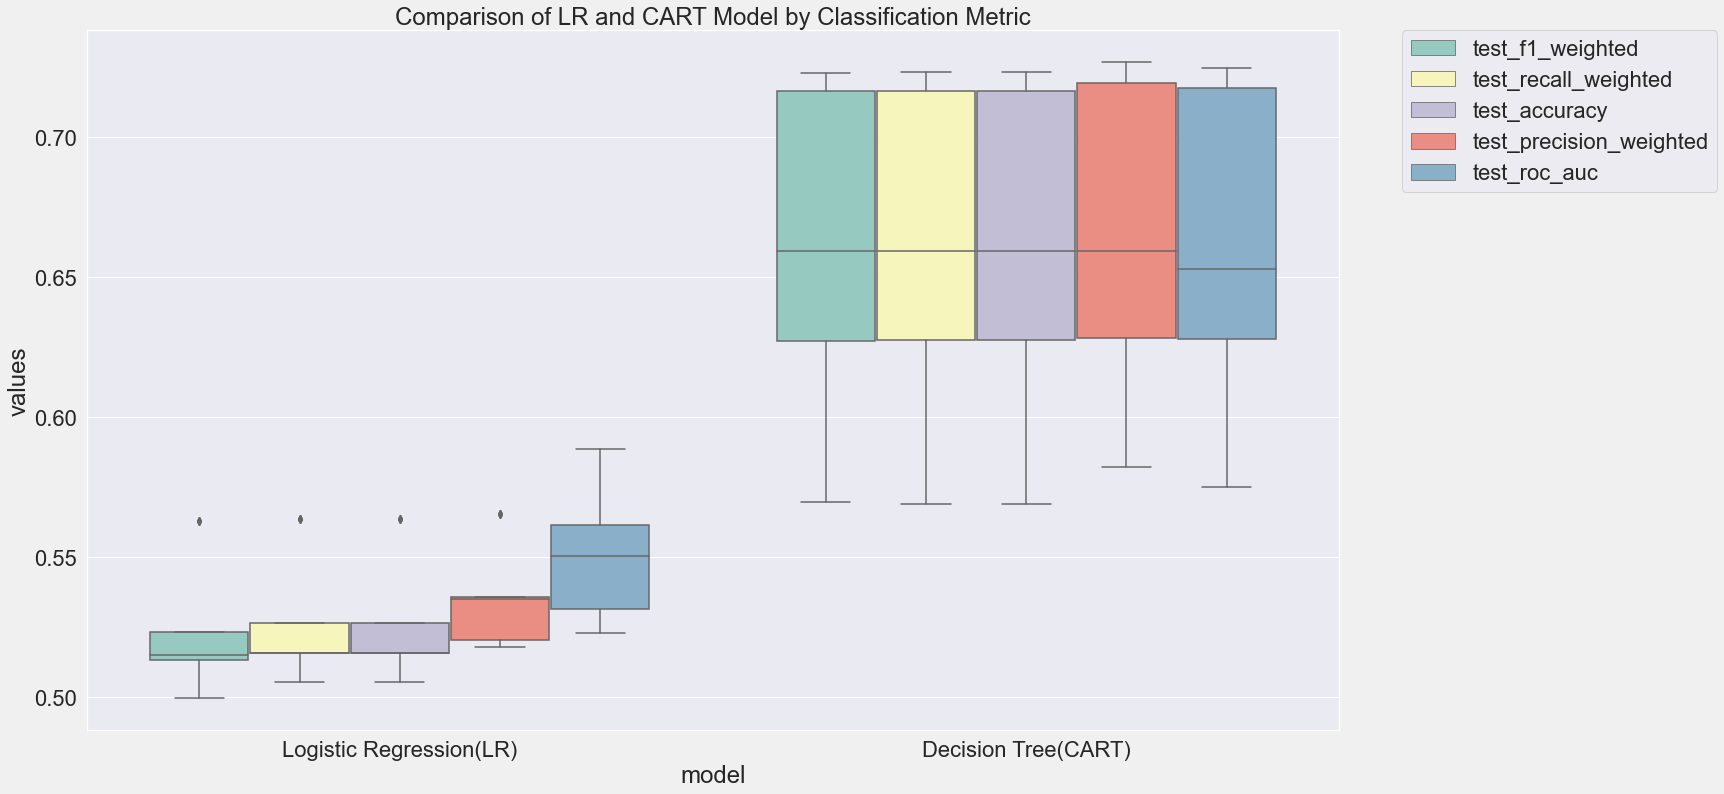

In [57]:
#Machine Learning models – Logistic regression and Decision tree to predict attrition and Comparison of Performance
perf_results_nofit, m_dataFrame = ml_ModelsComparison(result)

In [58]:
#Comparison of Performance metrics
metricValues = list(set(perf_results_nofit.metrics.values))
m_dataFrame.groupby(['model'])[metricValues].agg([np.std, np.mean]) #aggregate metric values with standard deviation and mean

test_accuracy           test_roc_auc            \
                                  std      mean          std      mean   
model                                                                    
Decision Tree(CART)          0.051748  0.664362     0.050895  0.664010   
Logistic Regression(LR)      0.021886  0.526418     0.024113  0.553019   

                        test_precision_weighted           test_f1_weighted  \
                                            std      mean              std   
model                                                                        
Decision Tree(CART)                    0.049535  0.667187         0.051506   
Logistic Regression(LR)                0.017539  0.536833         0.023100   

                                  test_recall_weighted            
                             mean                  std      mean  
model                                                             
Decision Tree(CART)      0.664313             0.051748  0.664362  
Logistic Regression(LR)  0.523979             0.021886  0.526418

In [98]:
# Feature Selection 2 - Chi Square And Mutual Info
dfFeature2 = df
featSelect2=selected_features_chi2(dfFeature2)+selected_features_mutual_info(dfFeature2)
featSelect2=list(set(featSelect2))
dfFeature2 = dfFeature2[featSelect2]
dfFeature2.head(2)

Train Feature City
Chi-square 1: 0.038088
Train Feature Customer Type
Chi-square 2: 0.748093
Train Feature Gender
Chi-square 3: 0.131567
Train Feature Product Type
Chi-square 4: 0.142722
Train Feature Unit Price
Chi-square 5: 75.024084
Train Feature Quantity
Chi-square 6: 3.527606
Train Feature Tax 
Chi-square 7: 24.298932
Train Feature Payment Type
Chi-square 8: 0.059518


In [99]:
#Feature Encoding (To Numerical)
dfFeature2 = transformToNumerical(dfFeature2)
dfFeature2.head(2)

After Encoding to numerical(First 10 records):



,Payment Type,Quantity,City,Product Type,Customer Type,Unit Price,Tax
0,2,7,0,3,0,392,9
1,0,5,2,0,1,72,202


In [100]:
dfFeature2 = minMaxScaler(dfFeature2)
dfFeature2.head(2)

,Payment Type,Quantity,City,Product Type,Customer Type,Unit Price,Tax
0,1.0,0.666667,0.0,0.6,0.0,0.416136,0.009100
1,0.0,0.444444,1.0,0.0,1.0,0.076433,0.204247


In [101]:
#Splitting the Dataset to Train and Test
X = dfFeature2.iloc[:, 0:dfFeature2.shape[1]]
Y = df.iloc[:, -1]
    
#Split the data into 75% training and 25% testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.30, random_state = 0)

In [102]:
#PCA Dimensionality Reduction
X_train, X_test = dimReductionPCA(X_train, X_test)

Variance attributed to each of the principal components:
[0.25614839 0.17987653 0.16566006 0.12139265 0.10967181 0.08726594
 0.07998461]


In [103]:
#Handling Imbalanced Dataset
X_train_smtom, y_train_smtom = handleClassImbalance(X_train, Y_train)

Before Sampling:
Counter({0: 479, 1: 221})
After Sampling:
Counter({0: 445, 1: 445})


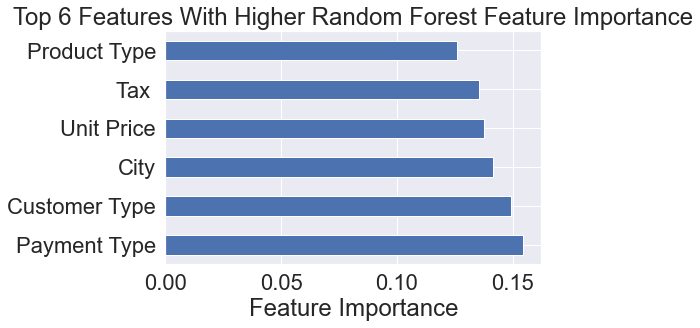

In [104]:
#RandomForest Model for important features
randomforest = randomForestModel(X_train_smtom, y_train_smtom)
importantFeatures(randomforest, dfFeature2)

Logistic Regression(LR)

Confusion Matrix:
            Predicted Low  High
Actual Low             94    86
High                   56    64

Accuracy:
52.67 %

Cross Validation Accuracy:
48.09 %

Classification Report:
              precision    recall  f1-score   support

         Low       0.63      0.52      0.57       180
        High       0.43      0.53      0.47       120

    accuracy                           0.53       300
   macro avg       0.53      0.53      0.52       300
weighted avg       0.55      0.53      0.53       300


Receiver Operating Characteristic(ROC):
Decision Tree(CART)

Confusion Matrix:
            Predicted Low  High
Actual Low            122    58
High                   68    52

Accuracy:
58.0 %

Cross Validation Accuracy:
66.07 %

Classification Report:
              precision    recall  f1-score   support

         Low       0.64      0.68      0.66       180
        High       0.47      0.43      0.45       120

    accuracy                         

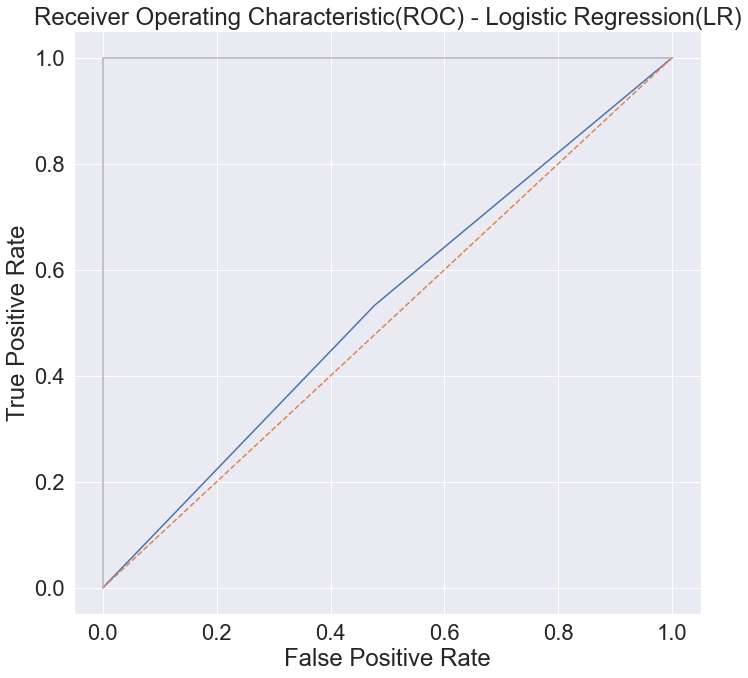

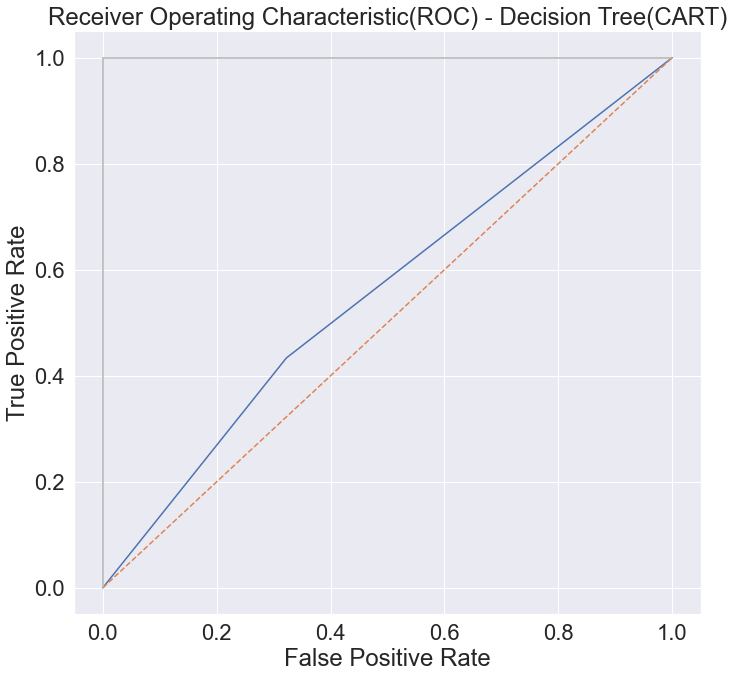

In [105]:
#Implement machine learning models to predict and gets the result of model and its performance metric values
result = mlPredict(X_train_smtom, y_train_smtom, Y_test) 

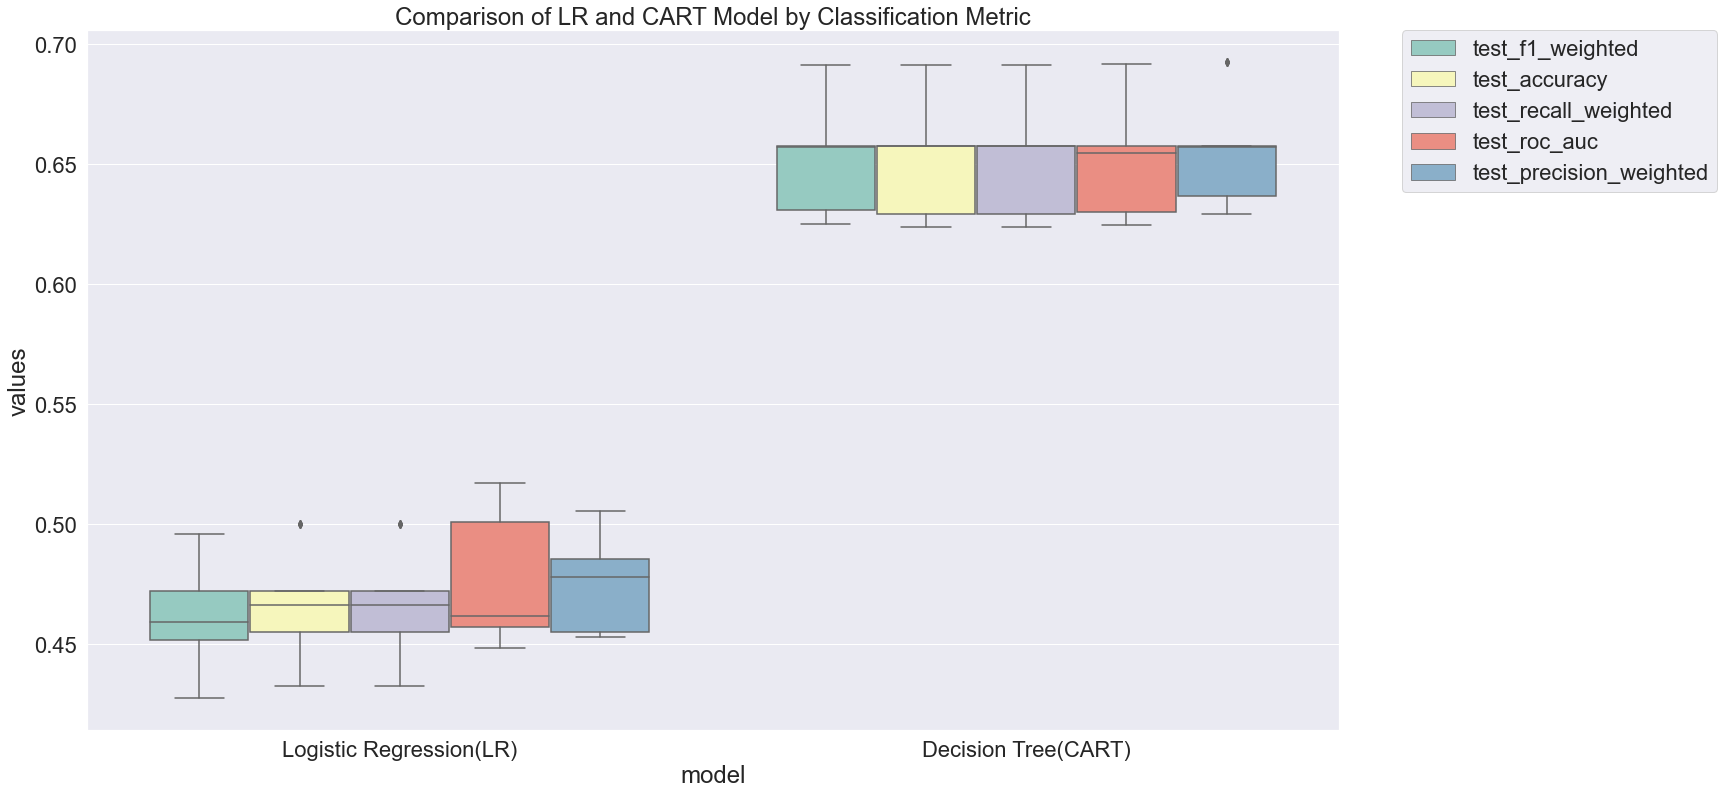

In [106]:
#Machine Learning models – Logistic regression and Decision tree to predict attrition and Comparison of Performance
perf_results_nofit, m_dataFrame = ml_ModelsComparison(result)

In [107]:
#Comparison of Performance metrics
metricValues = list(set(perf_results_nofit.metrics.values))
m_dataFrame.groupby(['model'])[metricValues].agg([np.std, np.mean]) #aggregate metric values with standard deviation and mean

test_accuracy           test_roc_auc            \
                                  std      mean          std      mean   
model                                                                    
Decision Tree(CART)          0.024039  0.655243     0.023906  0.655088   
Logistic Regression(LR)      0.024077  0.464419     0.028565  0.476824   

                        test_precision_weighted           test_f1_weighted  \
                                            std      mean              std   
model                                                                        
Decision Tree(CART)                    0.021998  0.657759         0.023502   
Logistic Regression(LR)                0.021453  0.474291         0.024543   

                                  test_recall_weighted            
                             mean                  std      mean  
model                                                             
Decision Tree(CART)      0.655744             0.024039  0.655243  
Logistic Regression(LR)  0.460167             0.024077  0.464419